# Project 2 - Object Detection


 - **Student Name**: Tomas David Medina Romero


Dear Students, 

Welcome the second project!! 
We will help you to implement another basic computer vision task: **Object Detection**. 

Object detection is a computer technology related to computer vision and image processing that deals with detecting instances of semantic objects of a certain class (such as humans, buildings, or cars) in digital images and videos. Well-researched domains of object detection include face detection and pedestrian detection. Object detection has applications in many areas of computer vision, including image retrieval and video surveillance.

Methods for object detection generally fall into either machine learning-based approaches or deep learning-based approaches. For Machine Learning approaches, it becomes necessary to first define features using one of the methods below, then using a technique such as support vector machine (SVM) to do the classification. On the other hand, deep learning techniques are able to do end-to-end object detection without specifically defining features, and are typically based on convolutional neural networks (CNN) such as Faster-RCNN and YOLO. 

In the project, you will be asked to fill missing parts of the implementation of [YOLOv3](https://pjreddie.com/darknet/yolo/) (You Only Look Once), a real-time object detection algorithm. 

Please be noted that:
 - You can refer to the [YOLO](https://arxiv.org/pdf/1506.02640.pdf), [YOLOv2](https://arxiv.org/pdf/1612.08242.pdf), and [YOLOv3](https://pjreddie.com/media/files/papers/YOLOv3.pdf) papers.   
 - Please read the instructions carefully. 
 - We provide reference outputs and we will judge your solution based on your code as well as on the quality of your output and similarity to our results.
 
There are also some reading materials and codes. Feel free to learn from public resources:
- object detection (and tracking) tutorial: https://towardsdatascience.com/object-detection-and-tracking-in-pytorch-b3cf1a696a98
- YOLOv3 tutorial: https://towardsdatascience.com/training-yolo-for-object-detection-in-pytorch-with-your-custom-dataset-the-simple-way-1aa6f56cf7d9
- Torchvision tutorial on object detection: https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**This is the first challenging project in the course.** YOLO is a complicate model for beginners, and there are many technique detail that we must be very careful. Whenever you have a question, look for more reading materials and codes.

## Import modules

In [ ]:
!pip install livelossplot

In [ ]:
from __future__ import division
import os
import sys
import time
import datetime
import argparse
import math

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import Dataset
from livelossplot import PlotLosses
import torch.nn as nn
from torchvision.transforms import functional as F
import numpy as np
from PIL import Image
from collections import defaultdict
import glob
import random

from skimage.transform import resize as resize

import torch
from torch.utils.data import DataLoader
import torchvision.transforms as T


# 1. PennFudan: Object Detection Dataset (30 points)

To make the project 2 easier, we use the [PennFudan dataset](https://www.cis.upenn.edu/~jshi/ped_html/) to train and test our model. It is an image database for pedestrian detection. The images are taken from scenes around campus and urban street. Each image will have at least one pedestrian in it.

In PennFudan dataset:
- There are 170 images with 345 labeled pedestrians.
- The heights of labeled pedestrians in this database fall into [180,390] pixels. 
- All labeled pedestrians are straight up.


Sample images and labeled masks

<img src="/content/drive/My Drive/Deep Learning/project2/asset/dataset.png" width="800">

In the Object Detection project, we will **ONLY** detect pedestrians from an image, or predict the labeled green bounding box. In the next segmantation project, we will learn to **predict the mask**.

## 1.1 Defining the dataset (20 points)

In [ ]:
class PennFudanDataset(Dataset):
    def __init__(self, list_path, img_size=416, transforms=None):
        with open(list_path, 'r') as file:
            self.img_files = file.readlines()
        self.label_files = [path.replace('Images', 'Masks').replace('.png', '_mask.png') for path in self.img_files]
        self.img_shape = (img_size, img_size)
        self.max_objects = 5
        self.transforms = transforms

    def __getitem__(self, index):

        #---------
        #  Image
        #---------

        img_path = self.img_files[index % len(self.img_files)].rstrip()
        img_path = "/content/drive/My Drive/Deep Learning/project2/"+img_path[2:]
        img = np.array(Image.open(img_path))

        # Handles images with less than three channels
        while len(img.shape) != 3:
            index += 1
            img_path = self.img_files[index % len(self.img_files)].rstrip()
            img_path = "/content/drive/My Drive/Deep Learning/project2/"+img_path[2:]
            img = np.array(Image.open(img_path))

        h, w, _ = img.shape
        dim_diff = np.abs(h - w)
        # Upper (left) and lower (right) padding
        pad1, pad2 = dim_diff // 2, dim_diff - dim_diff // 2
        # Determine padding
        pad = ((pad1, pad2), (0, 0), (0, 0)) if h <= w else ((0, 0), (pad1, pad2), (0, 0))
        # Add padding
        input_img = np.pad(img, pad, 'constant', constant_values=128) / 255.
        padded_h, padded_w, _ = input_img.shape
        # Resize and normalize
        input_img = resize(input_img, (*self.img_shape, 3), mode='reflect')
        # Channels-first
        input_img = np.transpose(input_img, (2, 0, 1))
        # As pytorch tensor
        input_img = torch.from_numpy(input_img).float()

        #---------
        #  Label
        #---------

        label_path = self.label_files[index % len(self.img_files)].rstrip()
        label_path = "/content/drive/My Drive/Deep Learning/project2/"+label_path[2:]

        assert os.path.exists(label_path), 'annotation file {} not found'.format(label_path)
        mask = Image.open(label_path)
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]
        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([0.0, xmin, ymin, xmax, ymax])
            
        labels = np.array(boxes)
        print("Label",labels)
        x1, y1, x2, y2 = labels[:,1], labels[:,2], labels[:,3], labels[:,4]
        # Adjust for added padding
        x1 += pad[1][0]
        y1 += pad[0][0]
        x2 += pad[1][0]
        y2 += pad[0][0]

        #########################################################################################################
        # TODO: fill the code below to complete labels - 20 points
        # This part of the code saves the labels in this format: 
        #          [class, x, y, width (of box), height (of box)] Centro del bounding box
        # 
        # Given the original labels array, normalize x, y, w, h of the object between 0 and 1 
        # using the padded_w and padded_h of the full image
        #########################################################################################################  
        #labels = None
        a3 = (x2 - x1)
        b3 = (y2 - y1)
        labels[:, 1] = ((x1 + x2) // 2) / padded_w
        labels[:, 2] = ((y1 + y2) // 2) / padded_h
        labels[:, 3] = a3 / padded_w
        labels[:, 4] = b3 / padded_h
        # Fill matrix
        filled_labels = np.zeros((self.max_objects, 5))
        if labels is not None:
            filled_labels[range(len(labels))[:self.max_objects]] = labels[:self.max_objects]
        filled_labels = torch.from_numpy(filled_labels)

            
        if self.transforms is not None:
            input_img, filled_labels = self.transforms(input_img, filled_labels)
            
        return img_path, input_img, filled_labels

    def __len__(self):
        return len(self.img_files)

    
    def vis(self, index):
        img_path, input_img, labels = self.__getitem__(index)
        print('input_img shape is {}'.format(input_img.shape))
        padded_h, padded_w, _ = input_img.shape
        fig, ax = plt.subplots(1, figsize=(12,9))
        ax.imshow(input_img.permute(1,2,0))
        # print(labels)
        for c,x, y, w, h in labels:
            if x==0:
                break
            # print(c,x,y,w,h)
            # print(input_img.shape)
            box_h = h * input_img.shape[1]
            box_w = w * input_img.shape[2]
            y1 = ((y - h / 2) ) * input_img.shape[1]
            x1 = ((x - w / 2) ) * input_img.shape[2]
            # print(box_h,box_w,x1,y1)
            bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, color='r', facecolor='none',fill=False)
            ax.add_patch(bbox)
            plt.text(x1, y1, s='person', color='white', verticalalignment='top',bbox={'color':'r', 'pad': 0})



That’s all for the dataset. Now let’s move to data augumentation to create more variance on this dataset.

## 1.2 Data Augumentation (10 points)

Data augmentation is a strategy that enables practitioners to significantly increase the diversity of data available for training models, without actually collecting new data. Data augmentation techniques such as cropping, padding, and horizontal flipping are commonly used to train large neural networks. [details](https://bair.berkeley.edu/blog/2019/06/07/data_aug/)

PyTorch includes those operations in the torchvision.transforms packages. Read more [here].(https://pytorch.org/docs/stable/torchvision/transforms.html)

We use two augumentation methods: **RandomHorizontalFlip** and **ColorJitter**. 
- RandomHorizontalFlip operation horizontally flips the given PIL Image randomly with a given probability. 
- ColorJitter operation randomly changes the brightness, contrast and saturation of an image.

In object detection, when we apply data augumentation on images, **we should decide if we adjust their labels accordingly**.

In [ ]:


class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target


class RandomHorizontalFlip(object):
    def __init__(self, prob=0.5):
        self.prob = prob

    def __call__(self, image, target):
        if random.random() < self.prob:
            #             height, width = image.shape[-2:]
            image = image.flip(-1)
            #########################################################################################################
            #TODO: fill the code below to perform the horizontal flip - 10 points
            ######################################################################################################### 
            bbox = target.detach().clone()# c,x,y,w,h
            bbox[:,1] = 1 - bbox[:,1]
            target = bbox
        return image, target

class ColorJitter(object):
    def __init__(self, brightness=0, contrast=0, saturation=0, hue=0):
        self.cj = T.ColorJitter(brightness, contrast, saturation,hue)
        
    def __call__(self, image, target):
        image = F.to_pil_image(image)
        image = self.cj(image)
        image = F.to_tensor(image)
        return image, target    

class ToTensor(object):
    def __call__(self, image, target):
        image = F.to_tensor(image)
        return image, target

def get_transform(train):
    transforms = []
    # transforms.append(ToTensor())
    if train:
        transforms.append(RandomHorizontalFlip(0.5))
        transforms.append(ColorJitter(0.03,0.03,0.03,0.03))
    return Compose(transforms)

# 2. Intersection over Union for object detection (10 points)

Intersection over Union is an evaluation metric used to measure the accuracy of an object detector on a particular dataset. 

In order to apply Intersection over Union to evaluate an (arbitrary) object detector we need:
- The ground-truth bounding boxes (i.e., the hand labeled bounding boxes from the testing set that specify where in the image our object is).
- The predicted bounding boxes from our model.
As long as we have these two sets of bounding boxes we can apply Intersection over Union.

Below there is a visual example of a ground-truth bounding box versus a predicted bounding box:

<img src="asset/iou_example.jpg" width="400">

Figure 1: An example of detecting a stop sign in an image. The predicted bounding box is drawn in red while the ground-truth bounding box is drawn in green. Our goal is to compute the Intersection of Union between these bounding boxes.

In the figure above we can see that our object detector has detected the presence of a stop sign in an image.

The predicted bounding box is drawn in red while the ground-truth (i.e., hand labeled) bounding box is drawn in green.

Computing Intersection over Union can therefore be determined via:

<img src="asset/iou_formula.png" width="400">

Figure 2: Computing the Intersection over Union is as simple as dividing the area of overlap between the bounding boxes by the area of union (thank you to the excellent Pittsburg HW4 assignment for the inspiration for this figure).

- In the numerator we compute the area of overlap between the predicted bounding box and the ground-truth bounding box.
- The denominator is the area of union, or more simply, the area encompassed by both the predicted bounding box and the ground-truth bounding box.
- Dividing the area of overlap by the area of union yields our final score — the Intersection over Union.

In [ ]:
def bbox_iou(box1, box2, x1y1x2y2=True):
    """
    Returns the IoU of two bounding boxes
    """
    if not x1y1x2y2:
        # Transform from center and width to exact coordinates
        b1_x1, b1_x2 = box1[:, 0] - box1[:, 2] / 2, box1[:, 0] + box1[:, 2] / 2
        b1_y1, b1_y2 = box1[:, 1] - box1[:, 3] / 2, box1[:, 1] + box1[:, 3] / 2
        b2_x1, b2_x2 = box2[:, 0] - box2[:, 2] / 2, box2[:, 0] + box2[:, 2] / 2
        b2_y1, b2_y2 = box2[:, 1] - box2[:, 3] / 2, box2[:, 1] + box2[:, 3] / 2
    else:
        # Get the coordinates of bounding boxes
        b1_x1, b1_y1, b1_x2, b1_y2 = box1[:, 0], box1[:, 1], box1[:, 2], box1[:, 3]
        b2_x1, b2_y1, b2_x2, b2_y2 = box2[:, 0], box2[:, 1], box2[:, 2], box2[:, 3]

    #########################################################################################################
    #TODO: get the corrdinates of the intersection rectangle - 10 points
    ######################################################################################################### 
    inter_rect_x1 = torch.max(b1_x1,b2_x1)
    inter_rect_y1 = torch.max(b1_y1,b2_y1)
    inter_rect_x2 = torch.min(b1_x2,b2_x2)
    inter_rect_y2 = torch.min(b1_y2,b2_y2)
    # Intersection area
    inter_area = torch.clamp(inter_rect_x2 - inter_rect_x1 + 1, min=0) * torch.clamp(
        inter_rect_y2 - inter_rect_y1 + 1, min=0
    )
    # Union Area
    b1_area = (b1_x2 - b1_x1 + 1) * (b1_y2 - b1_y1 + 1)
    b2_area = (b2_x2 - b2_x1 + 1) * (b2_y2 - b2_y1 + 1)

    iou = inter_area / (b1_area + b2_area - inter_area + 1e-16)

    return iou


def bbox_iou_numpy(box1, box2):
    """Computes IoU between bounding boxes.
    Parameters
    ----------
    box1 : ndarray
        (N, 4) shaped array with bboxes
    box2 : ndarray
        (M, 4) shaped array with bboxes
    Returns
    -------
    : ndarray
        (N, M) shaped array with IoUs
    """
    area = (box2[:, 2] - box2[:, 0]) * (box2[:, 3] - box2[:, 1])

    iw = np.minimum(np.expand_dims(box1[:, 2], axis=1), box2[:, 2]) - np.maximum(
        np.expand_dims(box1[:, 0], 1), box2[:, 0]
    )
    ih = np.minimum(np.expand_dims(box1[:, 3], axis=1), box2[:, 3]) - np.maximum(
        np.expand_dims(box1[:, 1], 1), box2[:, 1]
    )

    iw = np.maximum(iw, 0)
    ih = np.maximum(ih, 0)

    ua = np.expand_dims((box1[:, 2] - box1[:, 0]) * (box1[:, 3] - box1[:, 1]), axis=1) + area - iw * ih

    ua = np.maximum(ua, np.finfo(float).eps)

    intersection = iw * ih

    return intersection / ua



# 3. YOLO model (30 points)
<img src="asset/YOLOv3Arch.png" width="1000">

YOLO is a single covolutional network. That makes it faster compared to popular 2-stage detection systems. These systems apply the model to an image at multiple locations and scales. High scoring regions of the image are considered detections. 

With YOLO we have a single neural network being applied to the full image. This network divides the image into regions and predicts bounding boxes and probabilities for each region. These bounding boxes are weighted by the predicted probabilities.

[Here](https://blog.paperspace.com/how-to-implement-a-yolo-object-detector-in-pytorch/) is a series of tutorials to teach how to build YOLOv3 from scratch. Read them whenever you have questions in the project or in the paper. YOLO is a complicated model for beginners, but you only need to fill in some lines of code in this project.

## 3.1 Building layers

### Empty Layer (0 points)
This layer acts as a placeholder for 'route' and 'shortcut' layers. You do not need to modify it.

In [ ]:
class EmptyLayer(nn.Module):
    """Placeholder for 'route' and 'shortcut' layers"""

    def __init__(self):
        super(EmptyLayer, self).__init__()


### Detection Layer (30 points)

First, we need to generate the labels for the predictions. You do not need to modify the function below. 

In [ ]:
def build_targets(
    pred_boxes, pred_conf, pred_cls, target, anchors, num_anchors, num_classes, grid_size, ignore_thres, img_dim
):
    nB = target.size(0)
    nA = num_anchors
    nC = num_classes
    nG = grid_size
    mask = torch.zeros(nB, nA, nG, nG)
    conf_mask = torch.ones(nB, nA, nG, nG)
    tx = torch.zeros(nB, nA, nG, nG)
    ty = torch.zeros(nB, nA, nG, nG)
    tw = torch.zeros(nB, nA, nG, nG)
    th = torch.zeros(nB, nA, nG, nG)
    tconf = torch.ByteTensor(nB, nA, nG, nG).fill_(0)
    tcls = torch.ByteTensor(nB, nA, nG, nG, nC).fill_(0)

    nGT = 0
    nCorrect = 0
    for b in range(nB):
        for t in range(target.shape[1]):
            if target[b, t, -2:].sum() == 0:
                continue
            nGT += 1
            # Convert to position relative to box
            gx = target[b, t, 1] * nG
            gy = target[b, t, 2] * nG
            gw = target[b, t, 3] * nG
            gh = target[b, t, 4] * nG
            # Get grid box indices
            gi = int(gx)
            gj = int(gy)
            # Get shape of gt box
            gt_box = torch.FloatTensor(np.array([0, 0, gw, gh])).unsqueeze(0)
            # Get shape of anchor box
            anchor_shapes = torch.FloatTensor(np.concatenate((np.zeros((len(anchors), 2)), np.array(anchors)), 1))
            # Calculate iou between gt and anchor shapes
            anch_ious = bbox_iou(gt_box, anchor_shapes)
            # Where the overlap is larger than threshold set mask to zero (ignore)
            conf_mask[b, anch_ious > ignore_thres, gj, gi] = 0
            # Find the best matching anchor box
            best_n = np.argmax(anch_ious)
            # Get ground truth box
            gt_box = torch.FloatTensor(np.array([gx, gy, gw, gh])).unsqueeze(0)
            # Get the best prediction
            pred_box = pred_boxes[b, best_n, gj, gi].unsqueeze(0)
            # Masks
            mask[b, best_n, gj, gi] = 1
            conf_mask[b, best_n, gj, gi] = 1
            # Coordinates
            tx[b, best_n, gj, gi] = gx - gi
            ty[b, best_n, gj, gi] = gy - gj
            # Width and height
            tw[b, best_n, gj, gi] = math.log(gw / anchors[best_n][0] + 1e-16)
            th[b, best_n, gj, gi] = math.log(gh / anchors[best_n][1] + 1e-16)
            # One-hot encoding of label
            target_label = int(target[b, t, 0])
            # print(target)
            tcls[b, best_n, gj, gi, target_label] = 1
            tconf[b, best_n, gj, gi] = 1

            # Calculate iou between ground truth and best matching prediction
            iou = bbox_iou(gt_box, pred_box, x1y1x2y2=False)
            pred_label = torch.argmax(pred_cls[b, best_n, gj, gi])
            score = pred_conf[b, best_n, gj, gi]
            if iou > 0.5 and pred_label == target_label and score > 0.5:
                nCorrect += 1

    return nGT, nCorrect, mask, conf_mask, tx, ty, tw, th, tconf, tcls



Below is the module for the YOLO detection layer. Refer to the papers and complete the missing parts of the code below.

In [ ]:
class YOLOLayer(nn.Module):
    """Detection layer"""

    def __init__(self, anchors, num_classes, img_dim):
        super(YOLOLayer, self).__init__()
        self.anchors = anchors
        self.num_anchors = len(anchors)
        self.num_classes = num_classes
        self.bbox_attrs = 5 + num_classes
        self.image_dim = img_dim
        self.ignore_thres = 0.5
        self.lambda_coord = 1

        self.mse_loss = nn.MSELoss(size_average=True)  # Coordinate loss
        self.bce_loss = nn.BCELoss(size_average=True)  # Confidence loss
        self.ce_loss = nn.CrossEntropyLoss()  # Class loss

    def forward(self, x, targets=None):
        '''
         x is nB x (5 + C) x nG x nG tensor, where nB is a batch size,
         C is a number of classes in the dataset,
         (nG x nG) is number of grid cells
        '''
        nA = self.num_anchors
        nB = x.size(0)
        nG = x.size(2)
        stride = self.image_dim / nG
        # Tensors for cuda support
        FloatTensor = torch.cuda.FloatTensor if x.is_cuda else torch.FloatTensor
        LongTensor = torch.cuda.LongTensor if x.is_cuda else torch.LongTensor
        # ByteTensor = torch.cuda.ByteTensor if x.is_cuda else torch.ByteTensor
        ByteTensor = torch.cuda.BoolTensor if x.is_cuda else torch.BoolTensor


        prediction = x.view(nB, nA, self.bbox_attrs, nG, nG).permute(0, 1, 3, 4, 2).contiguous()

        # Get outputs
        x = torch.sigmoid(prediction[..., 0])  # Center x
        y = torch.sigmoid(prediction[..., 1])  # Center y
        w = prediction[..., 2]  # Width
        h = prediction[..., 3]  # Height
        pred_conf = torch.sigmoid(prediction[..., 4])  # Conf
        pred_cls = torch.sigmoid(prediction[..., 5:])  # Cls pred.

        # Calculate offsets for each grid
        grid_x = torch.arange(nG).repeat(nG, 1).view([1, 1, nG, nG]).type(FloatTensor)
        grid_y = torch.arange(nG).repeat(nG, 1).t().view([1, 1, nG, nG]).type(FloatTensor)
        scaled_anchors = FloatTensor([(a_w / stride, a_h / stride) for a_w, a_h in self.anchors])
        anchor_w = scaled_anchors[:, 0:1].view((1, nA, 1, 1))
        anchor_h = scaled_anchors[:, 1:2].view((1, nA, 1, 1))

        # Add offset and scale with anchors
        pred_boxes = FloatTensor(prediction[..., :4].shape)
        #########################################################################################################
        # TODO: fill the code below to add offset and scale each coordinate - 15 points
        # Hint: you need to add offset for the x, y coordinates and scale the height and width of the anchors
        #########################################################################################################        
        pred_boxes[..., 0] = x.data * grid_x
        pred_boxes[..., 1] = y.data * grid_y
        pred_boxes[..., 2] = torch.exp(w.data) * anchor_w
        pred_boxes[..., 3] = torch.exp(h.data) * anchor_h

        # Training
        if targets is not None:

            if x.is_cuda:
                self.mse_loss = self.mse_loss.cuda()
                self.bce_loss = self.bce_loss.cuda()
                self.ce_loss = self.ce_loss.cuda()

            nGT, nCorrect, mask, conf_mask, tx, ty, tw, th, tconf, tcls = build_targets(
                pred_boxes=pred_boxes.cpu().data,
                pred_conf=pred_conf.cpu().data,
                pred_cls=pred_cls.cpu().data,
                target=targets.cpu().data,
                anchors=scaled_anchors.cpu().data,
                num_anchors=nA,
                num_classes=self.num_classes,
                grid_size=nG,
                ignore_thres=self.ignore_thres,
                img_dim=self.image_dim,
            )

            nProposals = int((pred_conf > 0.5).sum().item())
            recall = float(nCorrect / nGT) if nGT else 1
            precision = 0
            if nProposals > 0:
                precision = float(nCorrect / nProposals)

            # Handle masks
            mask = Variable(mask.type(ByteTensor))
            conf_mask = Variable(conf_mask.type(ByteTensor))

            # Handle target variables
            tx = Variable(tx.type(FloatTensor), requires_grad=False)
            ty = Variable(ty.type(FloatTensor), requires_grad=False)
            tw = Variable(tw.type(FloatTensor), requires_grad=False)
            th = Variable(th.type(FloatTensor), requires_grad=False)
            tconf = Variable(tconf.type(FloatTensor), requires_grad=False)
            tcls = Variable(tcls.type(LongTensor), requires_grad=False)

            # Get conf mask where gt and where there is no gt
            conf_mask_true = mask
            # conf_mask_false = conf_mask - mask
            conf_mask_false = conf_mask ^ mask

            # Mask outputs to ignore non-existing objects
            loss_x = self.mse_loss(x[mask], tx[mask])
            loss_y = self.mse_loss(y[mask], ty[mask])
            loss_w = self.mse_loss(w[mask], tw[mask])
            loss_h = self.mse_loss(h[mask], th[mask])
            #########################################################################################################
            # TODO: define the loss for confidence scores - 15 points
            #########################################################################################################    
            loss_true = self.bce_loss(pred_conf[conf_mask_true],tconf[conf_mask_true])  
            loss_false = self.bce_loss(pred_conf[conf_mask_false],tconf[conf_mask_false])      
            loss_conf = loss_true + loss_false
            
            loss_cls = (1 / nB) * self.ce_loss(pred_cls[mask], torch.argmax(tcls[mask], 1))
            loss = loss_x + loss_y + loss_w + loss_h + loss_conf + loss_cls

            return (
                loss,
                loss_x.item(),
                loss_y.item(),
                loss_w.item(),
                loss_h.item(),
                loss_conf.item(),
                loss_cls.item(),
                recall,
                precision,
            )

        else:
            # If not in training phase return predictions
            output = torch.cat(
                (
                    pred_boxes.view(nB, -1, 4) * stride,
                    pred_conf.view(nB, -1, 1),
                    pred_cls.view(nB, -1, self.num_classes),
                ),
                -1,
            )
            return output



## 3.2 Building modules (0 points)
Here we combine our  YOLO detection layer and Empty layers with Pytorch built-in modules (Convolutional and Upsample). The function returns the list of hyperparameters and the list of all YOLO modules.
You do not need to modify anything here.

In [ ]:
def create_modules(module_defs):
    """
    Constructs module list of layer blocks from module configuration in module_defs
    """
    hyperparams = module_defs.pop(0)
    output_filters = [int(hyperparams["channels"])]
    module_list = nn.ModuleList()
    for i, module_def in enumerate(module_defs):
        modules = nn.Sequential()

        if module_def["type"] == "convolutional":
            bn = int(module_def["batch_normalize"])
            filters = int(module_def["filters"])
            kernel_size = int(module_def["size"])
            pad = (kernel_size - 1) // 2 if int(module_def["pad"]) else 0
            modules.add_module(
                "conv_%d" % i,
                nn.Conv2d(
                    in_channels=output_filters[-1],
                    out_channels=filters,
                    kernel_size=kernel_size,
                    stride=int(module_def["stride"]),
                    padding=pad,
                    bias=not bn,
                ),
            )
            if bn:
                modules.add_module("batch_norm_%d" % i, nn.BatchNorm2d(filters))
            if module_def["activation"] == "leaky":
                modules.add_module("leaky_%d" % i, nn.LeakyReLU(0.1))

        elif module_def["type"] == "maxpool":
            kernel_size = int(module_def["size"])
            stride = int(module_def["stride"])
            if kernel_size == 2 and stride == 1:
                padding = nn.ZeroPad2d((0, 1, 0, 1))
                modules.add_module("_debug_padding_%d" % i, padding)
            maxpool = nn.MaxPool2d(
                kernel_size=int(module_def["size"]),
                stride=int(module_def["stride"]),
                padding=int((kernel_size - 1) // 2),
            )
            modules.add_module("maxpool_%d" % i, maxpool)

        elif module_def["type"] == "upsample":
            upsample = nn.Upsample(scale_factor=int(module_def["stride"]), mode="nearest")
            modules.add_module("upsample_%d" % i, upsample)

        elif module_def["type"] == "route":
            layers = [int(x) for x in module_def["layers"].split(",")]
            filters = sum([output_filters[layer_i] for layer_i in layers])
            modules.add_module("route_%d" % i, EmptyLayer())

        elif module_def["type"] == "shortcut":
            filters = output_filters[int(module_def["from"])]
            modules.add_module("shortcut_%d" % i, EmptyLayer())

        elif module_def["type"] == "yolo":
            anchor_idxs = [int(x) for x in module_def["mask"].split(",")]
            # Extract anchors
            anchors = [int(x) for x in module_def["anchors"].split(",")]
            anchors = [(anchors[i], anchors[i + 1]) for i in range(0, len(anchors), 2)]
            anchors = [anchors[i] for i in anchor_idxs]
            num_classes = int(module_def["classes"])
            img_height = int(hyperparams["height"])
            # Define detection layer
            yolo_layer = YOLOLayer(anchors, num_classes, img_height)
            modules.add_module("yolo_%d" % i, yolo_layer)
        # Register module list and number of output filters
        module_list.append(modules)
        output_filters.append(filters)

    return hyperparams, module_list


## 3.3 Configs (0 points)
In this homework we will not train the model from scratch (that would take a lot of time) but use configuration and weights from the model pre-trained on the COCO dataset. You do not need to modify anything here.

The model and data settings are saved in the _config_ folders.
This [blog](https://www.google.com/amp/s/blog.paperspace.com/how-to-implement-a-yolo-v3-object-detector-from-scratch-in-pytorch-part-2/amp/) explains the config files. Please read it if you have any question. 

In [ ]:
def parse_model_config(path):
    """Parses the yolo-v3 layer configuration file and returns module definitions"""
    file = open(path, "r")
    lines = file.read().split('\n')
    lines = [x for x in lines if x and not x.startswith('#')]
    lines = [x.rstrip().lstrip() for x in lines] # get rid of fringe whitespaces
    module_defs = []
    for line in lines:
        if line.startswith('['): # This marks the start of a new block
            module_defs.append({})
            module_defs[-1]['type'] = line[1:-1].rstrip()
            if module_defs[-1]['type'] == 'convolutional':
                module_defs[-1]['batch_normalize'] = 0
        else:
            key, value = line.split("=")
            value = value.strip()
            module_defs[-1][key.rstrip()] = value.strip()

    return module_defs

def parse_data_config(path):
    """Parses the data configuration file"""
    options = dict()
    options['gpus'] = '0,1,2,3'
    options['num_workers'] = '10'
    with open(path, 'r') as fp:
        lines = fp.readlines()
    for line in lines:
        line = line.strip()
        if line == '' or line.startswith('#'):
            continue
        key, value = line.split('=')
        options[key.strip()] = value.strip()
    return options


## 3.4 Weight initialization (0 points)
Here we to initialize our trainable layers. You do not need to modify anything here.

In [ ]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)



## 3.5 Main Model (0 points)
Here is the code which builds the whole YOLO model.  

In [ ]:
class YOLOv3(nn.Module):
    """YOLOv3 object detection model"""

    def __init__(self, config_path, img_size=416):
        super(YOLOv3, self).__init__()
        self.module_defs = parse_model_config(config_path)
        self.hyperparams, self.module_list = create_modules(self.module_defs)
        self.img_size = img_size
        self.seen = 0
        self.header_info = np.array([0, 0, 0, self.seen, 0])
        self.loss_names = ["x", "y", "w", "h", "conf", "cls", "recall", "precision"]

    def forward(self, x, targets=None):
        is_training = targets is not None
        output = []
        self.losses = defaultdict(float)
        layer_outputs = []
        for i, (module_def, module) in enumerate(zip(self.module_defs, self.module_list)):
            if module_def["type"] in ["convolutional", "upsample", "maxpool"]:
                x = module(x)
            elif module_def["type"] == "route":
                layer_i = [int(x) for x in module_def["layers"].split(",")]
                x = torch.cat([layer_outputs[i] for i in layer_i], 1)
            elif module_def["type"] == "shortcut":
                layer_i = int(module_def["from"])
                x = layer_outputs[-1] + layer_outputs[layer_i]
            elif module_def["type"] == "yolo":
                # Train phase: get loss
                if is_training:
                    x, *losses = module[0](x, targets)
                    for name, loss in zip(self.loss_names, losses):
                        self.losses[name] += loss
                # Test phase: Get detections
                else:
                    x = module(x)
                output.append(x)
            layer_outputs.append(x)

        self.losses["recall"] /= 3
        self.losses["precision"] /= 3
        return sum(output) if is_training else torch.cat(output, 1)

# 4. Train and Validation (5 points)

## 4.1 Hyperparameters and paths (5 points)

In [ ]:
epochs = 1000
image_folder = "/content/drive/My Drive/Deep Learning/project2/data/PennFudan/Images"
batch_size = 4
model_config_path = "/content/drive/My Drive/Deep Learning/project2/config/yolov3cls1.cfg"
data_config_path = "/content/drive/My Drive/Deep Learning/project2/config/ped.data"
pt_weight_path = "/content/drive/My Drive/Deep Learning/project2/yolov3.weights.pt"
class_path = "/content/drive/My Drive/Deep Learning/project2/config/ped.names"
conf_thres = 0.8
nms_thres = 0.4
n_cpu = 0
img_size = 416
checkpoint_interval = 5
checkpoint_dir = "/content/drive/My Drive/Deep Learning/project2/checkpoints"
use_cuda = True
#########################################################################################################
#TODO: tune the learning rate - 5 points
######################################################################################################### 
learning_rate = 0.025

#fp = open(data_config_path,"r")
#print(fp)

In [ ]:
cuda = torch.cuda.is_available() and use_cuda
os.makedirs("checkpoints", exist_ok = True)

In [ ]:
def load_classes(path):
    """
    Loads class labels at 'path'
    """
    fp = open(path, "r")
    names = fp.read().split("\n")[:-1]
    return names
classes = load_classes(class_path)

## 4.2 Loading the model (5 points)

In [ ]:
# Get data configuration
data_config = parse_data_config(data_config_path)
train_path = "/content/drive/My Drive/Deep Learning/project2/" + data_config["train"]
val_path = "/content/drive/My Drive/Deep Learning/project2/"+data_config["valid"]
# Initiate model
model = YOLOv3(model_config_path)
# model.load_weights(weights_path)
model.apply(weights_init_normal);
if cuda:
    model = model.cuda()

#print(train_path)

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [ ]:
static_weight = torch.load(pt_weight_path)

for module_id in ['81', '93', '105']:
    keys = [k for k in static_weight.keys() if module_id in k]
    assert len(keys)==2, print(keys)
#     new_weight = static_weight[keys[0]].reshape(3,85,-1,1,1)[:,:6,...].reshape(18,-1,1,1)
#     new_bias   = static_weight[keys[1]].reshape(3,85)[:,:6,...].reshape(18)
#     print(keys,static_weight[keys[0]].shape,static_weight[keys[1]].shape,new_weight.shape,new_bias.shape)
#     static_weight[keys[0]] = new_weight
#     static_weight[keys[1]] = new_bias
    del static_weight[keys[0]]
    del static_weight[keys[1]]
model.load_state_dict(static_weight,strict=False)

_IncompatibleKeys(missing_keys=['module_list.81.conv_81.weight', 'module_list.81.conv_81.bias', 'module_list.93.conv_93.weight', 'module_list.93.conv_93.bias', 'module_list.105.conv_105.weight', 'module_list.105.conv_105.bias'], unexpected_keys=[])

In [ ]:
# Freeze the shallow layers
for i, (name, p) in enumerate(model.named_parameters()): 
    if p.shape[0] != 18:
        p.requires_grad = False
    else:
        p.requires_grad = True
        print('Optimize {}-th weight {}, with shape {}'.format(i,name,p.shape))

Optimize 174-th weight module_list.81.conv_81.weight, with shape torch.Size([18, 1024, 1, 1])
Optimize 175-th weight module_list.81.conv_81.bias, with shape torch.Size([18])
Optimize 197-th weight module_list.93.conv_93.weight, with shape torch.Size([18, 512, 1, 1])
Optimize 198-th weight module_list.93.conv_93.bias, with shape torch.Size([18])
Optimize 220-th weight module_list.105.conv_105.weight, with shape torch.Size([18, 256, 1, 1])
Optimize 221-th weight module_list.105.conv_105.bias, with shape torch.Size([18])


In [ ]:
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),lr=learning_rate)

In [ ]:
# Get dataloader
dataloader_train = torch.utils.data.DataLoader(
    PennFudanDataset(train_path,transforms=get_transform(train=True)), batch_size=batch_size, shuffle=True, num_workers=n_cpu
)
dataloader_val = torch.utils.data.DataLoader(
    PennFudanDataset(val_path), batch_size=batch_size, shuffle=False, num_workers=n_cpu
)


Label [[  0.  21.  90. 142. 405.]
 [  0. 130.  92. 204. 357.]
 [  0. 236.  82. 311. 355.]
 [  0. 342. 116. 387. 266.]
 [  0. 385. 115. 426. 249.]]
input_img shape is torch.Size([3, 416, 416])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:128: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.


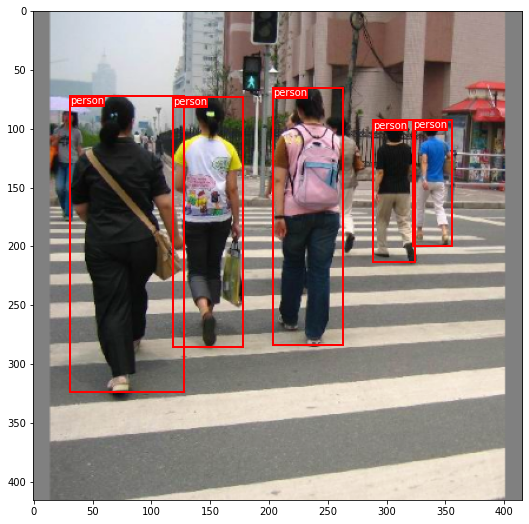

In [ ]:
dataloader_train.dataset.vis(5)

In [ ]:
liveloss = PlotLosses()
def avg(lst):
    return sum(lst)/len(lst)

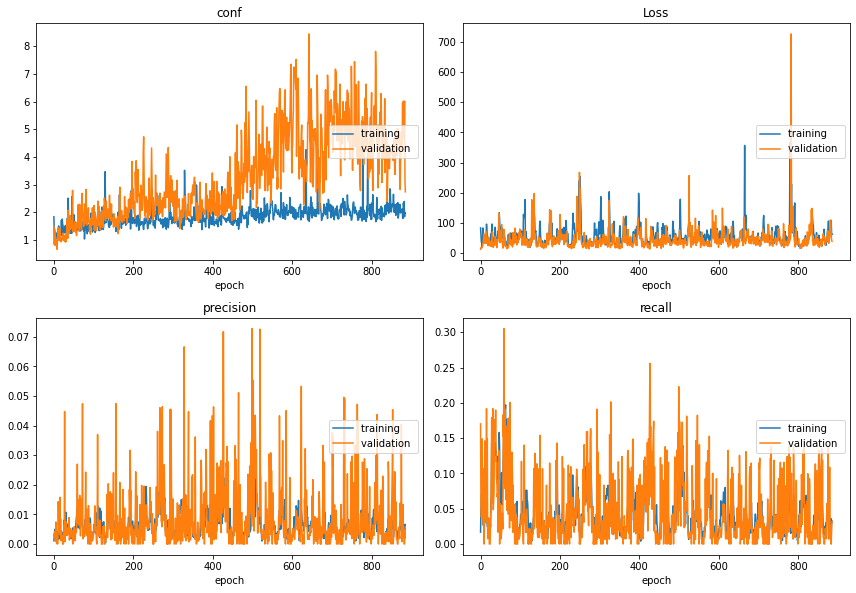

conf
	training         	 (min:    1.031, max:    4.289, cur:    1.973)
	validation       	 (min:    0.659, max:    8.452, cur:    2.738)
Loss
	training         	 (min:   16.146, max:  365.564, cur:   62.429)
	validation       	 (min:   12.378, max:  726.916, cur:   38.823)
precision
	training         	 (min:    0.000, max:    0.029, cur:    0.005)
	validation       	 (min:    0.000, max:    0.073, cur:    0.006)
recall
	training         	 (min:    0.002, max:    0.197, cur:    0.033)
	validation       	 (min:    0.000, max:    0.305, cur:    0.031)


RuntimeError: ignored

In [ ]:
for epoch in range(epochs):
    logs = {}
    dataloader = {'train': dataloader_train, 'val': dataloader_val}
    for phase in ['train', 'val']:
        losses ,recalls, precisions, confs = [], [], [] ,[]
        if phase == 'train':
                model.train()
        else:
                model.eval()
                
        for batch_i, (_, imgs, targets) in enumerate(dataloader[phase]):
            imgs = Variable(imgs.type(Tensor))
            targets = Variable(targets.type(Tensor), requires_grad=False)

            loss = model(imgs, targets)

            if phase == 'train':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                #########################################################################################################
                #TODO: make an optimization step to train the model - 5 points
                ######################################################################################################### 

            losses.append(loss.item())
            recalls.append(model.losses["recall"])
            precisions.append(model.losses["precision"])
            confs.append(model.losses["conf"])
            
            print(
            "[%s: Epoch %d/%d, Batch %d/%d] [Losses: x %f, y %f, w %f, h %f, conf %f, cls %f, total %f, recall: %.5f, precision: %.5f]"
            % (
                phase,
                epoch,
                epochs,
                batch_i,
                len(dataloader),
                model.losses["x"],
                model.losses["y"],
                model.losses["w"],
                model.losses["h"],
                model.losses["conf"],
                model.losses["cls"],
                loss.item(),
                model.losses["recall"],
                model.losses["precision"],
            )
        )

        prefix = ''
        if phase == 'val':
            prefix = 'val_'
        logs[prefix+'loss'] = avg(losses)
        logs[prefix+'conf'] = avg(confs)
        logs[prefix+'recall'] = avg(recalls)
        logs[prefix+'precision'] = avg(precisions)
        
    model.seen += imgs.size(0)

    liveloss.update(logs)
    liveloss.draw()
    
    if epoch % checkpoint_interval == 0:
        torch.save(model.state_dict(), "%s/%d.weights.pt" % (checkpoint_dir, epoch))
        # model.save_weights("%s/%d.weights" % (checkpoint_dir, epoch))


# 5. Test (20 points)


## 5.1 NMS (10 points)

To begin with, let's learn a new concept, Non-maximum Suppression (NMS). 

One of the problems of Object Detection is that your algorithm may find multiple detections of the same objects. Rather than detecting an object just once, it might detect it multiple times. Non-max suppression is a way for you to make sure that your algorithm detects each object only once. 

Please watch [the videos](https://www.coursera.org/lecture/convolutional-neural-networks/non-max-suppression-dvrjH) for details, and complete the NMS function. 

<video src="https://d3c33hcgiwev3.cloudfront.net/HeCQ4bq2EeeBfg6A3Ng9Ng.processed/full/360p/index.webm?Expires=1582070400&amp;Signature=Kr~PG0NsqJ~zXe2rFSYniQ7QbrHJSIPt68WYIrCsyNY1~8FNFwZE3MmSx6tBB-WVkMK13wLq1qpL5anw3wA0ZqlNkZ4kyfrdcUXG2hXaiCXbTX4L0vFUcpKy--okuMeHBJzgBdOJfC53NXkpEls52w5LPcCAP6E8vJJkrDz2d4A_&amp;Key-Pair-Id=APKAJLTNE6QMUY6HBC5A"></video>

In [ ]:
def non_max_suppression(prediction, num_classes, conf_thres=0.5, nms_thres=0.4):
    """
    Removes detections with lower object confidence score than 'conf_thres' and performs
    Non-Maximum Suppression to further filter detections.
    Returns detections with shape:
        (x1, y1, x2, y2, object_conf, class_score, class_pred)
    """

    #########################################################################################################
    #TODO: From (center x, center y, width, height) to (x1, y1, x2, y2), 5 points
    ######################################################################################################### 
    box_corner = prediction.new(prediction.shape)
    box_corner[:, :, 0] = (predicton[:,:,0] - prediction[:,:,2])/2
    box_corner[:, :, 1] = (prediction[:,:,1] - prediction[:,:,3])/2
    box_corner[:, :, 2] = (prediction[:,:,0] + prediction[:,:,2])/2
    box_corner[:, :, 3] = (prediction[:,:,1] + prediction[:,:,3])/2
    
    prediction[:, :, :4] = box_corner[:, :, :4]

    output = [None for _ in range(len(prediction))]
    for image_i, image_pred in enumerate(prediction):
        # Filter out confidence scores below threshold
        conf_mask = (image_pred[:, 4] >= conf_thres).squeeze()
        image_pred = image_pred[conf_mask]
        # If none are remaining => process next image
        if not image_pred.size(0):
            continue
        # Get score and class with highest confidence
        class_conf, class_pred = torch.max(image_pred[:, 5 : 5 + num_classes], 1, keepdim=True)
        # Detections ordered as (x1, y1, x2, y2, obj_conf, class_conf, class_pred)
        detections = torch.cat((image_pred[:, :5], class_conf.float(), class_pred.float()), 1)
        # Iterate through all predicted classes
        unique_labels = detections[:, -1].cpu().unique()
        if prediction.is_cuda:
            unique_labels = unique_labels.cuda()
        for c in unique_labels:
            # Get the detections with the particular class
            detections_class = detections[detections[:, -1] == c]
            # Sort the detections by maximum objectness confidence
            _, conf_sort_index = torch.sort(detections_class[:, 4], descending=True)
            detections_class = detections_class[conf_sort_index]
            # Perform non-maximum suppression
            max_detections = []
            while detections_class.size(0):
                # Get detection with highest confidence and save as max detection
                max_detections.append(detections_class[0].unsqueeze(0))
                # Stop if we're at the last detection
                if len(detections_class) == 1:
                    break
                # Get the IOUs for all boxes with lower confidence
                ious = bbox_iou(max_detections[-1], detections_class[1:])
                # Remove detections with IoU >= NMS threshold
                detections_class = detections_class[1:][ious < nms_thres]

            max_detections = torch.cat(max_detections).data
            #########################################################################################################
            #TODO: Add max detections to outputs, 5 points
            ######################################################################################################### 
            output[image_i] = max_detections

    return output


## 5.2 Loading the model and visualization (5 points)


If everything goes well, you will find a lot of files under the _checkpoints_ folder. They are the model weight saved in different training periods. In test, the task is to find a proper model weight that (1) contains enough infomation and (2) is not overfitted.

Usually we do not use the last-saved model weight because this weight is too closely fit to the training set, but does not fit the validation set well.
You should also look for the good confidence threshold to avoid false detections and to keep enough positive detections.

You need to choose a model weight as your **final decision**. Then, we will judge your solution based on the quality of your output and similarity to our results.

In [ ]:
config_path='/content/drive/My Drive/Deep Learning/project2/config/yolov3cls1.cfg'
class_path='/content/drive/My Drive/Deep Learning/project2/config/coco.names'
    #########################################################################################################
    #TODO: Load the trained model - 2 points
    ######################################################################################################### 
pt_weight_path = None

img_size = 416
    #########################################################################################################
    #TODO: Choose the confidence threshold to show the results - 3 points
    ######################################################################################################### 
conf_thres = None
nms_thres = 0.4

# Load model and weights
model = YOLOv3(config_path, img_size=img_size)
static_weight = torch.load(pt_weight_path)

model.load_state_dict(static_weight,strict=False)
model.cuda()
model.eval()
classes = load_classes(class_path)
Tensor = torch.cuda.FloatTensor

In [ ]:
def detect_image(img):
    # scale and pad image
    ratio = min(img_size/img.size[0], img_size/img.size[1])
    imw = round(img.size[0] * ratio)
    imh = round(img.size[1] * ratio)
    img_transforms = transforms.Compose([ transforms.Resize((imh, imw)),
         transforms.Pad((max(int((imh-imw)/2),0), max(int((imw-imh)/2),0), max(int((imh-imw)/2),0), max(int((imw-imh)/2),0)),
                        (128,128,128)),
         transforms.ToTensor(),
         ])
    # convert image to Tensor
    image_tensor = img_transforms(img).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input_img = Variable(image_tensor.type(Tensor))
    # run inference on the model and get detections
    with torch.no_grad():
        detections = model(input_img)
        detections = non_max_suppression(detections, 1, conf_thres, nms_thres)
    return detections[0]

This part will vizualize your predicted bounding boxes with class labels. 

In [ ]:
test_path = './data/PennFudan/test.txt'
with open(test_path, 'r') as file:
    test_files = file.readlines()
for f in test_files: 
    img_path = f.rstrip()
    prev_time = time.time()
    img = Image.open(img_path).convert('RGB')
    detections = detect_image(img)
    inference_time = datetime.timedelta(seconds=time.time() - prev_time)
    print ('Inference Time: %s' % (inference_time))

    # Get bounding-box colors
    cmap = plt.get_cmap('tab20b')
    colors = [cmap(i) for i in np.linspace(0, 1, 20)]

    img = np.array(img)
    plt.figure()
    fig, ax = plt.subplots(1, figsize=(12,9))
    ax.imshow(img)

    pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
    pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
    unpad_h = img_size - pad_y
    unpad_w = img_size - pad_x

    if detections is not None:
        unique_labels = detections[:, -1].cpu().unique()
        n_cls_preds = len(unique_labels)
        bbox_colors = random.sample(colors, n_cls_preds)
        # browse detections and draw bounding boxes
        for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:
            box_h = ((y2 - y1) / unpad_h) * img.shape[0]
            box_w = ((x2 - x1) / unpad_w) * img.shape[1]
            y1 = ((y1 - pad_y // 2) / unpad_h) * img.shape[0]
            x1 = ((x1 - pad_x // 2) / unpad_w) * img.shape[1]
            color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
            bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor='none')
            ax.add_patch(bbox)
            plt.text(x1, y1, s=classes[int(cls_pred)], color='white', verticalalignment='top',
                    bbox={'color': color, 'pad': 0})
    plt.axis('off')
    #save image
    plt.savefig(f'./predictions/{img_path.split("/")[-1]}', bbox_inches='tight', pad_inches=0.0)
    plt.show()
#     plt.imshow(f'./asset/{img_path.split("/")[-1].split(".")[0]}-reference.png')

## 5.3 Reference solutions (5 points)
Here are detection examples we obtained by running our trained model. Try to get similar or **better** qualitative results!

<img src= 'asset/PennPed00060-reference.png' width="400" height="200"> <img src= 'asset/PennPed00023-reference.png' width="390" height="200">

<img src= 'asset/PennPed00077-reference.png' width="330" height="200"> <img src= 'asset/PennPed00014-reference.png' width="450" height="200">